In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import scipy.io as sio
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from examples.paper_figures.plot_config import params, contourLevels, colormap, savefig_format, SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE

# Apply plot settings
plt.rcParams.update(params)


In [ ]:
# Set directory containing fig_data folder
data_dir = ""

In [7]:
# Configuration parameters
model_str = ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'gencast', 'fuxis2s', 'ngcm']
yr_ar = np.arange(2019, 2025)  # [2019:2024]

# Models to show in maps
model_to_show = ['clim', 'ifs', 'ngcm']

# Find indices for specific models
clim_idx = model_str.index('clim')
ifs_idx = model_str.index('ifs')
ngcm_idx = model_str.index('ngcm')

print(f"Model indices - Climatology: {clim_idx}, IFS: {ifs_idx}, NGCM: {ngcm_idx}")
print(f"Year range: {yr_ar[0]}-{yr_ar[-1]}")
print(f"Models: {model_str}")

Model indices - Climatology: 0, IFS: 1, NGCM: 7
Year range: 2019-2024
Models: ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'gencast', 'fuxis2s', 'ngcm']


In [8]:

polygon_col = np.array([49, 130, 189]) / 256

map_col = 0.3*np.array([1, 1, 1])

# Titles
a_title = '(a) MAE (in days) for 1-15 day forecast'

b_title = '(b) MAE (in days) for 16-30 day forecast'
c_title = '(c) Deterministic skill of models for core monsoon zone (CMZ)'

# Define Core Monsoon Zone polygon
polygon1_lon = np.array([86, 74, 74, 70, 70, 82, 82, 86, 86])
polygon1_lat = np.array([18, 18, 22, 22, 30, 30, 26, 26, 18])

def create_ylorbr_colormap(n_colors):
    """Create YlOrRd-like colormap similar to MATLAB's brewermap"""
    colors = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#BD0026', '#800026']
    if n_colors <= len(colors):
        selected_colors = colors[:n_colors]
    else:
        selected_colors = colors
    return LinearSegmentedColormap.from_list('YlOrRd', selected_colors, N=n_colors)

print("Plotting parameters initialized")

Plotting parameters initialized


In [49]:
def get_india_outline():
    """
    Get India outline coordinates. First try to load from shapefile, 
    then fall back to simplified coordinates.
    """
    try:
        # PATH OF SHAPE FILE {CHANGE AS NEEDED}
        shapefile_paths = [
            f"{data_dir}/fig_data/ind_map_shpfile/india_shapefile.shp",
            'india_shapefile.shp'
        ]
        
        for path in shapefile_paths:
            try:
                import geopandas as gpd
                india_gdf = gpd.read_file(path)
                # Extract boundary coordinates
                boundaries = []
                for geom in india_gdf.geometry:
                    if hasattr(geom, 'exterior'):
                        coords = list(geom.exterior.coords)
                        lon_coords = [coord[0] for coord in coords]
                        lat_coords = [coord[1] for coord in coords]
                        boundaries.append((lon_coords, lat_coords))
                    elif hasattr(geom, 'geoms'):
                        for sub_geom in geom.geoms:
                            if hasattr(sub_geom, 'exterior'):
                                coords = list(sub_geom.exterior.coords)
                                lon_coords = [coord[0] for coord in coords]
                                lat_coords = [coord[1] for coord in coords]
                                boundaries.append((lon_coords, lat_coords))
                return boundaries
            except:
                continue
    except:
        raise FileNotFoundError("India outline shapefile not found.")
    
    return [(india_lon, india_lat)]

print("India outline function defined")

India outline function defined


In [50]:
# Load 1-15 day data from MAT files
try:
    # Define file paths
    file_15day = f"{data_dir}./fig_data/deterministic_scores_15_day_2019_2024.mat"
    file_30day = f"{data_dir}/fig_data/deterministic_scores_30_day_2019_2024.mat"
    print("Loading 15-day data...")
    data_15 = sio.loadmat(file_15day)
    print("Loading 30-day data...")
    data_30 = sio.loadmat(file_30day)
    
    # Extract coordinate data (assuming they're in the MAT files)
    # Check what variables are available in the MAT files
    print("Available variables in 15-day file:", [key for key in data_15.keys() if not key.startswith('__')])
    print("Available variables in 30-day file:", [key for key in data_30.keys() if not key.startswith('__')])
    
    # Extract coordinates - adjust variable names as needed based on your MAT file structure
    if 'lon' in data_15:
        lon = data_15['lon'].flatten()
        lat = data_15['lat'].flatten()
    elif 'longitude' in data_15:
        lon = data_15['longitude'].flatten()
        lat = data_15['latitude'].flatten()
    else:
        # If coordinates not found, use default range - you may need to adjust this
        print("Warning: Coordinates not found in MAT file, using default range")
        lon = np.arange(70, 101, 4)
        lat = np.arange(8, 39, 4)
    
    # Extract MAE data - adjust variable names as needed
    if 'mae_avg_15' in data_15:
        mae_avg_15 = data_15['mae_avg_15']
    elif 'mae_avg' in data_15:
        mae_avg_15 = data_15['mae_avg']
    else:
        # Try to find MAE-related variables
        mae_vars_15 = [key for key in data_15.keys() if 'mae' in key.lower() and not key.startswith('__')]
        if mae_vars_15:
            print(f"Found MAE variables in 15-day file: {mae_vars_15}")
            mae_avg_15 = data_15[mae_vars_15[0]]
        else:
            raise KeyError("Could not find MAE data in 15-day file")
    
    if 'mae_avg_30' in data_30:
        mae_avg_30 = data_30['mae_avg_30']
    elif 'mae_avg' in data_30:
        mae_avg_30 = data_30['mae_avg']
    else:
        # Try to find MAE-related variables
        mae_vars_30 = [key for key in data_30.keys() if 'mae' in key.lower() and not key.startswith('__')]
        if mae_vars_30:
            print(f"Found MAE variables in 30-day file: {mae_vars_30}")
            mae_avg_30 = data_30[mae_vars_30[0]]
        else:
            raise KeyError("Could not find MAE data in 30-day file")
    
    # Extract CMZ statistics - adjust variable names as needed
    def extract_variable(data_dict, var_names, default_size):
        """Helper function to extract variables with multiple possible names"""
        for var_name in var_names:
            if var_name in data_dict:
                return data_dict[var_name].flatten()
        print(f"Warning: Could not find variables {var_names}, using random data")
        return np.random.rand(default_size) * 10
    
    n_models = len(model_str)
    
    # Extract 15-day statistics
    mae_cmz_mean_15 = extract_variable(data_15, ['mae_cmz_mean_15', 'mae_cmz_mean', 'mae_mean'], n_models)
    std_er_15 = extract_variable(data_15, ['std_er_15', 'std_er', 'stderr'], n_models)
    far_cmz_mean_15 = extract_variable(data_15, ['far_cmz_mean_15', 'far_cmz_mean', 'far_mean'], n_models)
    mr_cmz_mean_15 = extract_variable(data_15, ['mr_cmz_mean_15', 'mr_cmz_mean', 'mr_mean'], n_models)
    mae_fixed_clim = extract_variable(data_15, ['mae_cmz_fixed_clim'], n_models)
    mae_fixed_std_er = extract_variable(data_15, ['std_er_fixed_clim'], n_models) 
    # Extract 30-day statistics
    mae_cmz_mean_30 = extract_variable(data_30, ['mae_cmz_mean_30', 'mae_cmz_mean', 'mae_mean'], n_models)
    std_er_30 = extract_variable(data_30, ['std_er_30', 'std_er', 'stderr'], n_models)
    far_cmz_mean_30 = extract_variable(data_30, ['far_cmz_mean_30', 'far_cmz_mean', 'far_mean'], n_models)
    mr_cmz_mean_30 = extract_variable(data_30, ['mr_cmz_mean_30', 'mr_cmz_mean', 'mr_mean'], n_models)

    print("Data loaded successfully!")
    print(f"Coordinate grid: {len(lon)} x {len(lat)}")
    print(f"15-day MAE data shape: {mae_avg_15.shape}")
    print(f"30-day MAE data shape: {mae_avg_30.shape}")
    print(f"Number of models: {n_models}")
    

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Using dummy data for demonstration")

Loading 15-day data...
Loading 30-day data...
Available variables in 15-day file: ['false_alarm_15', 'far_cmz_mean_15', 'lat', 'lon', 'mae_avg_15', 'mae_cmz_fixed_clim', 'mae_cmz_mean_15', 'mae_yr_15', 'miss_rate_15', 'mr_cmz_mean_15', 'std_er_15', 'std_er_fixed_clim']
Available variables in 30-day file: ['false_alarm_30', 'far_cmz_mean_30', 'lat', 'lon', 'mae_avg_30', 'mae_cmz_fixed_clim', 'mae_cmz_mean_30', 'mae_yr_30', 'miss_rate_30', 'mr_cmz_mean_30', 'std_er_30', 'std_er_fixed_clim']
Data loaded successfully!
Coordinate grid: 9 x 8
15-day MAE data shape: (9, 8, 8)
30-day MAE data shape: (9, 8, 8)
Number of models: 8


In [51]:
# Load additional data for extended period markers
model_str_extended = ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'gencast', 'fuxis2s', 'ngcm']

try:
    # Define file paths for extended period data
    file_15day_extended = "{data_dir}/fig_data/deterministic_scores_15_day_1965_1978_2019_2024_with_gencast.mat"
    file_30day_extended = "{data_dir}/fig_data/deterministic_scores_30_day_1965_1978_2019_2024_with_gencast.mat"

    print("Loading extended period data...")
    data_15_extended = sio.loadmat(file_15day_extended)
    data_30_extended = sio.loadmat(file_30day_extended)
    
    print("Available variables in extended 15-day file:", [key for key in data_15_extended.keys() if not key.startswith('__')])
    
    # Extract extended period statistics using the same helper function
    n_models_extended = len(model_str_extended)
    
    # Extract 15-day extended statistics
    mae_cmz_mean_15_extended = extract_variable(data_15_extended, ['mae_cmz_mean_15', 'mae_cmz_mean', 'mae_mean'], n_models_extended)
    std_er_15_extended = extract_variable(data_15_extended, ['std_er_15', 'std_er', 'stderr'], n_models_extended)
    far_cmz_mean_15_extended = extract_variable(data_15_extended, ['far_cmz_mean_15', 'far_cmz_mean', 'far_mean'], n_models_extended)
    mr_cmz_mean_15_extended = extract_variable(data_15_extended, ['mr_cmz_mean_15', 'mr_cmz_mean', 'mr_mean'], n_models_extended)
    
    # Extract 30-day extended statistics
    mae_cmz_mean_30_extended = extract_variable(data_30_extended, ['mae_cmz_mean_30', 'mae_cmz_mean', 'mae_mean'], n_models_extended)
    std_er_30_extended = extract_variable(data_30_extended, ['std_er_30', 'std_er', 'stderr'], n_models_extended)
    far_cmz_mean_30_extended = extract_variable(data_30_extended, ['far_cmz_mean_30', 'far_cmz_mean', 'far_mean'], n_models_extended)
    mr_cmz_mean_30_extended = extract_variable(data_30_extended, ['mr_cmz_mean_30', 'mr_cmz_mean', 'mr_mean'], n_models_extended)
    
    print("Extended period data loaded successfully!")
    
except FileNotFoundError as e:
    print(f"Error loading extended data: {e}")
    print("Using dummy extended data")
    # Create dummy data if files not found
    mae_cmz_mean_15_extended = mae_cmz_mean_15.copy()
    std_er_15_extended = std_er_15.copy()
    far_cmz_mean_15_extended = far_cmz_mean_15.copy()
    mr_cmz_mean_15_extended = mr_cmz_mean_15.copy()
    mae_cmz_mean_30_extended = mae_cmz_mean_30.copy()
    std_er_30_extended = std_er_30.copy()
    far_cmz_mean_30_extended = far_cmz_mean_30.copy()
    mr_cmz_mean_30_extended = mr_cmz_mean_30.copy()

Loading extended period data...
Error loading extended data: [Errno 2] No such file or directory: '{data_dir}/fig_data/deterministic_scores_15_day_1965_1978_2019_2024_with_gencast.mat'
Using dummy extended data


In [52]:
def create_map_panel_no_inset(ax, data_15, lon, lat, model_idx, model_name, 
                             mae_cmz_mean, std_er, far_cmz_mean, mr_cmz_mean,
                             vmin=0, vmax=15, n_colors=6, show_ylabel=True, title=None):
    """
    Create a map panel without insets and statistics text in bottom-right
    """
    
    # Create meshgrid for plotting
    lon_edges = np.concatenate([lon - (lon[1]-lon[0])/2, [lon[-1] + (lon[1]-lon[0])/2]])
    lat_edges = np.concatenate([lat - (lat[1]-lat[0])/2, [lat[-1] + (lat[1]-lat[0])/2]])
    LON_edges, LAT_edges = np.meshgrid(lon_edges, lat_edges)
    
    # Plot the main data
    plt_ar = data_15[:, :, model_idx]
    cmap = plt.cm.get_cmap('YlOrRd', n_colors)
    masked_data = np.ma.masked_invalid(plt_ar.T)
    
    # Use pcolormesh for proper grid cell alignment
    im = ax.pcolormesh(LON_edges, LAT_edges, masked_data, 
                       cmap=cmap, vmin=vmin, vmax=vmax, shading='flat')
    
    # Add India map outline
    india_boundaries = get_india_outline()
    for boundary in india_boundaries:
        india_lon, india_lat = boundary
        ax.plot(india_lon, india_lat, color='black', linewidth=map_lw)

    # Add polygon for Core Monsoon Zone
    polygon = Polygon(list(zip(polygon1_lon, polygon1_lat)), 
                     fill=False, edgecolor='black', linewidth=polygon_lw)
    ax.add_patch(polygon)
    
    # Add model name text in top-right
    ax.text(0.95, 0.95, model_name, transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='top',
            color='black', fontsize=MEDIUM_SIZE, fontweight='bold')

    # Add grid values as text
    for i, lon_val in enumerate(lon):
        for j, lat_val in enumerate(lat):
            if not np.isnan(plt_ar[i, j]):
                value = plt_ar[i, j]
                # Round to appropriate decimal places
                if value == 0:
                    rounded_val = '0'
                    color = 'black'
                elif value >= 15:
                    rounded_val = f'{value:.0f}'
                    color = 'white'
                elif value >= 1:
                    rounded_val = f'{value:.1f}'
                    color = 'black'
                else:
                    rounded_val = f'{value:.2f}'
                    color = 'black'
                
                ax.text(lon_val, lat_val, rounded_val,
                       ha='center', va='center',
                       color=color, fontsize=SMALL_SIZE)
    
    # Set axis limits and ticks
    ax.set_xlim([lon[0]-4, 100])
    ax.set_ylim([lat[0]-4, lat[-1]+4])
    
    # Create tick labels
    yticks = np.arange(lat[0]-2, lat[-1]+3, 8)
    yticklabels = [f"{int(y)}° N" if i % 1 == 0 else "" for i, y in enumerate(yticks)]
    ax.set_yticks(yticks)
    if show_ylabel:
        ax.set_yticklabels(yticklabels)
    else:
        ax.set_yticklabels([])
    
    xticks = np.arange(lon[0]-2, lon[-1]+3, 8)
    xticklabels = [f"{int(x)}° E" if i % 1 == 0 else "" for i, x in enumerate(xticks)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    # Add statistics text in BOTTOM-RIGHT corner
    stats_text = (f'MAE: {mae_cmz_mean[model_idx]:.1f}±{std_er[model_idx]:.1f}\n'
                  f'FAR: {far_cmz_mean[model_idx]:.1f}\%\n'
                  f'MR: {mr_cmz_mean[model_idx]:.1f}\%')
    ax.text(0.6, 0.02, stats_text, transform=ax.transAxes,
            color='black', fontsize=SMALL_SIZE,
            verticalalignment='bottom', horizontalalignment='left', fontweight='normal')

    # Remove grid lines
    ax.grid(False)
    ax.set_axisbelow(False)
    ax.tick_params('both', length=tick_length, width=tick_width, which='major')
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', left=False, right=False)

    if title:
        ax.text(0.02, 1.02, title, transform=ax.transAxes, 
                verticalalignment='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    return im



In [53]:
def create_map_panel_difference(ax, data_15, lon, lat, model_idx, clim_idx, model_name, 
                               mae_cmz_mean, std_er, far_cmz_mean, mr_cmz_mean,
                               vmin_diff=-10, vmax_diff=10, show_ylabel=True, title=None):
    """
    Create a map panel showing difference from climatology but with original numbers displayed
    Only write values for grids with non-NaN differences
    """
    
    # Create meshgrid for plotting
    lon_edges = np.concatenate([lon - (lon[1]-lon[0])/2, [lon[-1] + (lon[1]-lon[0])/2]])
    lat_edges = np.concatenate([lat - (lat[1]-lat[0])/2, [lat[-1] + (lat[1]-lat[0])/2]])
    LON_edges, LAT_edges = np.meshgrid(lon_edges, lat_edges)
    
    # Plot the DIFFERENCE data (model - climatology)
    diff_data = data_15[:, :, model_idx] - data_15[:, :, clim_idx]
    
    # Use diverging colormap for differences
    cmap = plt.cm.get_cmap('RdBu_r', 10)
    masked_diff = np.ma.masked_invalid(diff_data.T)
    
    # Use pcolormesh for difference data
    im = ax.pcolormesh(LON_edges, LAT_edges, masked_diff, 
                       cmap=cmap, vmin=vmin_diff, vmax=vmax_diff, shading='flat')
    
    # Add India map outline
    india_boundaries = get_india_outline()
    for boundary in india_boundaries:
        india_lon, india_lat = boundary
        ax.plot(india_lon, india_lat, color='black', linewidth=map_lw)
    
    # Add polygon for Core Monsoon Zone
    polygon = Polygon(list(zip(polygon1_lon, polygon1_lat)), 
                     fill=False, edgecolor='black', linewidth=polygon_lw)
    ax.add_patch(polygon)
    
    # Add model name text in top-right
    ax.text(0.95, 0.95, model_name, transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='top',
            color='black', fontsize=MEDIUM_SIZE, fontweight='bold')

    # Add ORIGINAL values as text ONLY for grids with non-NaN differences
    original_data = data_15[:, :, model_idx]
    for i, lon_val in enumerate(lon):
        for j, lat_val in enumerate(lat):
            # Only write values where difference is not NaN (i.e., where there's colored data)
            if not np.isnan(diff_data[i, j]) and not np.isnan(original_data[i, j]):
                value_col = diff_data[i, j]
                value = original_data[i, j]
                # Round to appropriate decimal places
                if value_col == 0:
                    rounded_val = '0'
                    color = 'black'
                elif value_col >= 5:
                    rounded_val = f'{value:.1f}'
                    color = 'white'
                elif value_col <= -5:
                    rounded_val = f'{value:.1f}'
                    color = 'white'
                else:
                    rounded_val = f'{value:.1f}'
                    color = 'black'
                
                ax.text(lon_val, lat_val, rounded_val,
                       ha='center', va='center', fontsize=SMALL_SIZE,
                       color=color)
    
    # Set axis limits and ticks
    ax.set_xlim([lon[0]-4, 100])
    ax.set_ylim([lat[0]-4, lat[-1]+4])
    
    # Create tick labels
    yticks = np.arange(lat[0]-2, lat[-1]+3, 8)
    yticklabels = [f"{int(y)}° N" if i % 1 == 0 else "" for i, y in enumerate(yticks)]
    ax.set_yticks(yticks)
    if show_ylabel:
        ax.set_yticklabels(yticklabels)
    else:
        ax.set_yticklabels([])
    
    xticks = np.arange(lon[0]-2, lon[-1]+3, 8)
    xticklabels = [f"{int(x)}° E" if i % 1 == 0 else "" for i, x in enumerate(xticks)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    # Add statistics text in BOTTOM-RIGHT corner
    stats_text = (f'MAE: {mae_cmz_mean[model_idx]:.1f}±{std_er[model_idx]:.1f}\n'
                  f'FAR: {far_cmz_mean[model_idx]:.1f}\%\n'
                  f'MR: {mr_cmz_mean[model_idx]:.1f}\%')
    ax.text(0.6, 0.02, stats_text, transform=ax.transAxes,
            color='black', fontsize=SMALL_SIZE,
            verticalalignment='bottom', horizontalalignment='left', fontweight='normal')
    
    # Remove grid lines
    ax.grid(False)
    ax.set_axisbelow(False)
    ax.tick_params('both', length=tick_length, width=tick_width, which='major')
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', left=False, right=False)

    if title:
        ax.text(0.02, 1.02, title, transform=ax.transAxes, 
                verticalalignment='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    return im

In [54]:
def create_bar_panel(ax, mae_data, std_er, far_data, mr_data, title, 
                    mae_data_extended, std_er_extended, far_data_extended, mr_data_extended,
                    show_ylabel=True, show_legend=False, panel_type='c'):
    """
    Create horizontal bar chart panel with MAE, FAR, and MR metrics
    Added extended period markers for specific models
    """
    
    # Colors
    mae_col = np.array([217, 95, 14]) / 256
    mr_col = np.array([33, 102, 172]) / 256
    far_col = np.array([146, 197, 222]) / 256
    cmiss_col = 'blue'
    
    # Bar parameters
    bar_height = -0.25
    
    # Group labels - exclude climatology from bars
    groups = ['IFS*', 'AIFS$^{\dagger}$', 'FuXi', 'GraphCast', 'GenCast', 'FuXi-S2S*', 'NGCM']
    
    # Models to show extended markers for
    models_with_markers = ['aifs', 'fuxi', 'graphcast', 'gencast', 'ngcm']
    
    marker_mapping = []  # (bar_chart_idx, extended_data_idx)
    marker_mapping_common = []  # (bar_chart_idx, extended_data_idx)
    for model in models_with_markers:
        if model in model_str:  # Check if model exists in 2019-2024 data
            # Get index in 2019-2024 data
            main_idx = model_str.index(model)
            bar_idx = main_idx - 1  # Convert to bar chart index (skip climatology)
            
            if model in model_str_extended:  # Check if model exists in extended data
                extended_idx = model_str_extended.index(model)
                extended_bar_idx = extended_idx - 1  # Convert to bar chart index (skip climatology)
                
                if bar_idx >= 0 and extended_bar_idx >= 0:
                    marker_mapping.append((bar_idx, extended_bar_idx))


    # Skip climatology (index 0) for bar data
    mae_data_no_clim = mae_data[1:]
    std_er_no_clim = std_er[1:]
    far_data_no_clim = far_data[1:]
    mr_data_no_clim = mr_data[1:]
    
    # Extended data (also skip climatology)
    mae_data_extended_no_clim = mae_data_extended[1:]
    std_er_extended_no_clim = std_er_extended[1:]
    far_data_extended_no_clim = far_data_extended[1:]
    mr_data_extended_no_clim = mr_data_extended[1:]
    

    y = np.arange(len(groups))
    
    # Create twin axes for different scales
    ax2 = ax.twiny()
    ax.set_zorder(ax2.get_zorder() + 1)  # Make ax draw on top of ax2
    ax.patch.set_visible(False)  # Make ax background transparent so ax2 shows through

    # Bottom axis - MAE bars (excluding climatology)
    bars_mae = ax.barh(y - bar_height, mae_data_no_clim, bar_height, color=mae_col, label='MAE')
    ax.errorbar(mae_data_no_clim, y - bar_height, xerr=std_er_no_clim, fmt='none', ecolor='k',
                linewidth=1, capsize=2)
    
    # Add extended period markers for MAE (specific models only)
    for bar_idx, extended_idx in marker_mapping:
        if extended_idx < len(mae_data_extended_no_clim):
            ax.errorbar(mae_data_extended_no_clim[extended_idx], y[bar_idx] - bar_height, 
                       xerr=std_er_extended_no_clim[extended_idx], 
                       fmt='o', color=mae_col, markersize=3.5, linewidth=1, capsize=2,
                       markerfacecolor=mae_col, markeredgecolor='black', markeredgewidth=0.75)

    
    # Add vertical patch for climatology MAE value
    mae_clim_center = mae_data[0]
    mae_clim_std = std_er[0]
    y_min, y_max = ax.get_ylim()

    mae_clim_extended_center = mae_data_extended[0]
    # mae_clim_commmon_center = mae_data_common[0]
    std_clim_extended = std_er_extended[0]
    # std_clim_common = std_er_common[0]

    
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (mae_clim_center - mae_clim_std, y_max),
        2 * mae_clim_std,
        y_min - y_max - 1,
        linewidth=0,
        edgecolor='none',
        facecolor=mae_col,
        alpha=0.25
    )
    ax.add_patch(rect)

    # Add central line for MAE climatology (2019-2024)
    #ax.axvline(mae_clim_center, color=mae_col, linestyle='-', linewidth=1.25, alpha=1,zorder=10)
    
    # Add marker for extended period climatology MAE on bottom x-axis
    ax.plot(mae_clim_extended_center, ax.get_ylim()[1]-0.10, marker='o', color=mae_col, 
            markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
            clip_on=False, zorder=0)
    ax.errorbar(mae_clim_extended_center, 6+(-2.35*bar_height), xerr=std_clim_extended, fmt='none', ecolor=mae_col,
                linewidth=1.5, capsize=2,clip_on=False)
    
    
    # Set MAE axis properties
    ax.set_xlabel('MAE (in days)', color=mae_col, fontsize=SMALL_SIZE)
    ax.spines['bottom'].set_color(tuple(mae_col))
    ax.spines['top'].set_color(tuple(mr_col))
    ax.set_xlim([0, 12])
    ax.set_xticks(np.arange(0, 13, 3))
    ax.tick_params(axis='x', labelcolor=mae_col)
    
    # Top axis - FAR and MR bars (excluding climatology)
    bars_far = ax2.barh(y, far_data_no_clim, bar_height, color=far_col, label='FAR')
    bars_mr = ax2.barh(y + bar_height, mr_data_no_clim, bar_height, color=mr_col, label='MR')
    

    # Add markers for extended period climatology FAR and MR on top x-axis
    ax2.plot(far_data_extended[0], ax2.get_ylim()[0]+0.9625, marker='o', color=far_col, 
             markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
             clip_on=False, zorder=0)
    ax2.plot(mr_data_extended[0], ax2.get_ylim()[0]+0.95, marker='o', color=mr_col, 
             markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
             clip_on=False, zorder=0)


    # Add extended period markers for FAR and MR (specific models only)
    for bar_idx, extended_idx in marker_mapping:
        if extended_idx < len(far_data_extended_no_clim):
            # FAR marker
            ax2.plot(far_data_extended_no_clim[extended_idx], y[bar_idx], 
                    marker='o', color='black', markersize=3.5,
                    markerfacecolor=far_col, markeredgecolor='black', markeredgewidth=0.75)
            # MR marker
            ax2.plot(mr_data_extended_no_clim[extended_idx], y[bar_idx] + bar_height, 
                    marker='o', color='black', markersize=3.5,
                    markerfacecolor=mr_col, markeredgecolor='black', markeredgewidth=0.75)
    
            
    # Set FAR/MR axis properties
#    ax2.set_xlabel('FAR / MR (%)', color=mr_col, fontsize=SMALL_SIZE)
    ax2.set_xlabel('FAR / MR (\%)', color=mr_col, fontsize=SMALL_SIZE)

    ax2.spines['top'].set_color(tuple(mr_col))
    ax2.xaxis.set_label_position('top')
    ax2.set_xlim([0, 80])
    ax2.set_xticks(np.arange(0, 81, 20))
    ax2.tick_params(axis='x', labelcolor=mr_col)
    ax2.xaxis.tick_top()
    
    # Remove minor ticks
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', left=False, right=False)
    ax2.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax2.tick_params(axis='y', which='minor', left=False, right=False)
    
    # Set y-axis with model names
    ax.set_yticks(y)
    if show_ylabel:
        ax.set_yticklabels(groups)
    else:
        ax.set_yticklabels([])
    
    #ax.invert_yaxis()
    ax.set_ylim([len(groups) - 0.4, -0.6])
    
    # Remove grid lines
    ax.grid(False)
    ax2.grid(False)
    
    # Title
    if title:
        ax.text(0.02, 1.2, title, transform=ax.transAxes, verticalalignment='top', fontsize=LARGE_SIZE)
    
    ax2.axvline(far_data[0], color=far_col, linestyle='-', linewidth=1.25, alpha=1)
    ax2.axvline(mr_data[0], color=mr_col, linestyle='-', linewidth=1.25, alpha=1)
    ax.axvline(mae_clim_center, color=mae_col, linestyle='-', linewidth=1.25, alpha=1)
    # Legend

    if show_legend:
        import matplotlib.patches as mpatches

        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        
        # Create custom legend entries
        clim_line = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, 
                              label='Climatology')
        extended_marker = plt.Line2D([0], [0], marker='o', color='black', linestyle='None',
                                   markersize=3.5, markerfacecolor='white', 
                                   markeredgecolor='black', markeredgewidth=0.75,
                                   label='Extended period')
        # Rectangle-like patch for recent test period to match bar appearance
        recent_patch = mpatches.Patch(facecolor='white', edgecolor='black',
                                     linewidth=0.75,
                                     label='Recent test period\n(2019-2024)')

        all_handles = lines1 + lines2 + [recent_patch, clim_line, extended_marker]
        all_labels = labels1 + labels2 + ['Recent test period\n(2019-2024)', 'Climatology\n(2019-2024)', 'Extended period\n(1965-1978 +\n2019-2024)']
        legend = ax2.legend(all_handles, all_labels, fontsize=SMALL_SIZE,
                            loc='lower right', frameon=False)

    return ax, ax2

## Loading data for Webster-Yang Index (WYI) onset

In [55]:
# Load WYI onset data
wyi_15day_path = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_15day_2019_2024.mat"
wyi_15day = sio.loadmat(wyi_15day_path)
mae_cmz_mean_15_wyi = wyi_15day['mae_avg'].flatten()
std_er_15_wyi = wyi_15day['std_er'].flatten()
far_cmz_mean_15_wyi = wyi_15day['false_alarm'].flatten()*100
mr_cmz_mean_15_wyi = wyi_15day['miss_rate'].flatten()*100
model_str_wyi = wyi_15day['model_str']
# Load 30-day data
wyi_30day_path = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_30day_2019_2024.mat"
wyi_30day = sio.loadmat(wyi_30day_path)
mae_cmz_mean_30_wyi = wyi_30day['mae_avg'].flatten()
std_er_30_wyi = wyi_30day['std_er'].flatten()
far_cmz_mean_30_wyi = wyi_30day['false_alarm'].flatten()*100
mr_cmz_mean_30_wyi = wyi_30day['miss_rate'].flatten()*100


# Load WYI onset data for extended period
wyi_15day_path_extended = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_15day_1965_1978_2019_2024_with_gencast.mat"
wyi_15day_extended = sio.loadmat(wyi_15day_path_extended)
mae_cmz_mean_extended_15_wyi = wyi_15day_extended['mae_avg'].flatten()
std_er_extended_15_wyi = wyi_15day_extended['std_er'].flatten()
far_cmz_mean_extended_15_wyi = wyi_15day_extended['false_alarm'].flatten()*100
mr_cmz_mean_extended_15_wyi = wyi_15day_extended['miss_rate'].flatten()*100

# Load 30-day data for extended period
wyi_30day_path_extended = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_30day_1965_1978_2019_2024_with_gencast.mat"
wyi_30day_extended = sio.loadmat(wyi_30day_path_extended)
mae_cmz_mean_extended_30_wyi = wyi_30day_extended['mae_avg'].flatten()
std_er_extended_30_wyi = wyi_30day_extended['std_er'].flatten()
far_cmz_mean_extended_30_wyi = wyi_30day_extended['false_alarm'].flatten()*100
mr_cmz_mean_extended_30_wyi = wyi_30day_extended['miss_rate'].flatten()*100

# Load WYI onset data for common period
wyi_15day_path_common = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_15day_2004_2021.mat"
wyi_15day_common = sio.loadmat(wyi_15day_path_common)
mae_cmz_mean_common_15_wyi = wyi_15day_common['mae_avg'].flatten()
std_er_common_15_wyi = wyi_15day_common['std_er'].flatten()
far_cmz_mean_common_15_wyi = wyi_15day_common['false_alarm'].flatten()*100
mr_cmz_mean_common_15_wyi = wyi_15day_common['miss_rate'].flatten()*100

# Load WYI onset data for common period
wyi_30day_path_common = f"{data_dir}/fig_data/wyi_onset_deterministic_metrics_30day_2004_2021.mat"
wyi_30day_common = sio.loadmat(wyi_30day_path_common)
mae_cmz_mean_common_30_wyi = wyi_30day_common['mae_avg'].flatten()
std_er_common_30_wyi = wyi_30day_common['std_er'].flatten()
far_cmz_mean_common_30_wyi = wyi_30day_common['false_alarm'].flatten()*100
mr_cmz_mean_common_30_wyi = wyi_30day_common['miss_rate'].flatten()*100


# Lead times for line plots (days)
lead_times = np.arange(1, 31)  # 1 to 30 days

line_model_names = ['Climatology', 'IFS*', 'AIFS$^{†}$', 'Fuxi', 'Graphcast', 'Gencast', 'Fuxi-S2S*', 'NeuralGCM']

# ...existing code... (keep all the function definitions: create_bar_panel_onset, create_heatmap_panel, etc.)



In [56]:
def create_bar_panel_onset(ax, mae_data, std_er, far_data, mr_data,
                           mae_data_extended, std_er_extended, far_data_extended, mr_data_extended,
                            title, show_ylabel=True, show_legend=False, panel_type='a'):
    """Create horizontal bar chart panel for onset metrics with climatology as vertical lines with shading"""
    
    # Colors
    mae_col = np.array([217, 95, 14]) / 256
    mr_col = np.array([33, 102, 172]) / 256
    far_col = np.array([146, 197, 222]) / 256
    
    # Bar parameters
    bar_height = -0.25
    
    # Group labels (without climatology) - REVERSED ORDER
    groups = ['NGCM', 'GenCast', 'GraphCast', 'FuXi', 'AIFS$^{†}$', 'IFS*']
    groups = ['IFS*', 'AIFS$^{\dagger}$', 'FuXi', 'GraphCast', 'GenCast', 'NGCM']
    model_str = ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'gencast', 'ngcm']
    model_str_extended = ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'gencast', 'ngcm']
    model_str_common = ['clim', 'ifs', 'aifs', 'fuxi', 'graphcast', 'ngcm']
    models_with_markers = ['aifs', 'fuxi', 'graphcast', 'gencast', 'ngcm']
    models_with_markers_common = ['ifs', 'aifs', 'fuxi', 'graphcast', 'ngcm']
    marker_mapping = []  # (bar_chart_idx, extended_data_idx)
    marker_mapping_common = []  # (bar_chart_idx, extended_data_idx)
    
    for model in models_with_markers:
        if model in model_str:  # Check if model exists in 2019-2024 data
            # Get index in 2019-2024 data
            main_idx = model_str.index(model)
            bar_idx = main_idx - 1  # Convert to bar chart index (skip climatology)
            
            if model in model_str_extended:  # Check if model exists in extended data
                extended_idx = model_str_extended.index(model)
                extended_bar_idx = extended_idx - 1  # Convert to bar chart index (skip climatology)
                
                if bar_idx >= 0 and extended_bar_idx >= 0:
                    marker_mapping.append((bar_idx, extended_bar_idx))


    # Remove climatology (first element) and reverse the data arrays
    mae_data_no_clim = mae_data[1:]  # Remove first, then reverse
    std_er_no_clim = std_er[1:]
    far_data_no_clim = far_data[1:] 
    mr_data_no_clim = mr_data[1:]

    # Extended data (also skip climatology)
    mae_data_extended_no_clim = mae_data_extended[1:]
    std_er_extended_no_clim = std_er_extended[1:]
    far_data_extended_no_clim = far_data_extended[1:]
    mr_data_extended_no_clim = mr_data_extended[1:]


    y = np.arange(len(groups))
    
    # Create twin axes for different scales
    ax2 = ax.twiny()  # Changed from twinx to twiny for top x-axis
    ax.set_zorder(ax2.get_zorder() + 1)  # Make ax draw on top of ax2
    ax.patch.set_visible(False)  # Make ax background transparent so ax2 shows through   

    # Bottom axis - MAE (horizontal bars) - only for models, not climatology
    bars_mae = ax.barh(y - bar_height, mae_data_no_clim, bar_height, color=mae_col, label='MAE')
    ax.errorbar(mae_data_no_clim, y - bar_height, xerr=std_er_no_clim, fmt='none', ecolor='k',
                linewidth=1, capsize=2, zorder=3)
    
    # Add extended period markers for MAE (specific models only)
    for bar_idx, extended_idx in marker_mapping:
        if extended_idx < len(mae_data_extended_no_clim):
            ax.errorbar(mae_data_extended_no_clim[extended_idx], y[bar_idx] - bar_height, 
                       xerr=std_er_extended_no_clim[extended_idx], 
                       fmt='o', color=mae_col, markersize=3.5, linewidth=1, capsize=2,
                       markerfacecolor=mae_col, markeredgecolor='black', markeredgewidth=0.75)


     # Add vertical patch for climatology MAE value
    mae_clim_center = mae_data[0]
    mae_clim_std = std_er[0]
    y_min, y_max = ax.get_ylim()

    mae_clim_extended_center = mae_data_extended[0]
    # mae_clim_commmon_center = mae_data_common[0]
    std_clim_extended = std_er_extended[0]
    # std_clim_common = std_er_common[0]
 

    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (mae_clim_center - mae_clim_std, y_max),
        2 * mae_clim_std,
        y_min - y_max - 1,
        linewidth=0,
        edgecolor='none',
        facecolor=mae_col,
        alpha=0.25
    )
    ax.add_patch(rect)

    # Add marker for extended period climatology MAE on bottom x-axis
    ax.plot(mae_clim_extended_center, 5.61, marker='o', color=mae_col, 
            markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
            clip_on=False, zorder=0)
    ax.errorbar(mae_clim_extended_center, 5.61, xerr=std_clim_extended, fmt='none', ecolor=mae_col,
                linewidth=1.5, capsize=2,clip_on=False)    
 
    # Set MAE axis properties
    ax.set_xlabel('MAE (in days)', color=mae_col, fontsize=SMALL_SIZE)
    ax.spines['bottom'].set_color(tuple(mae_col))
    ax.spines['top'].set_color(tuple(mr_col))
    ax.set_xlim([0, 12])
    ax.set_xticks(np.arange(0, 13, 3))
    ax.tick_params(axis='x', labelcolor=mae_col)    

    # Top axis - FAR and MR bars (excluding climatology)
    bars_far = ax2.barh(y, far_data_no_clim, bar_height, color=far_col, label='FAR')
    bars_mr = ax2.barh(y + bar_height, mr_data_no_clim, bar_height, color=mr_col, label='MR')

    # Add markers for extended period climatology FAR and MR on top x-axis
    ax2.plot(far_data_extended[0]-1, 0-0.61, marker='o', color=far_col, 
             markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
             clip_on=False, zorder=0)
    ax2.plot(mr_data_extended[0], 0-0.61, marker='o', color=mr_col, 
             markersize=3.5, markeredgecolor='black', markeredgewidth=0.75, 
             clip_on=False, zorder=0)


    # Add extended period markers for FAR and MR (specific models only)
    for bar_idx, extended_idx in marker_mapping:
        if extended_idx < len(far_data_extended_no_clim):
            # FAR marker
            ax2.plot(far_data_extended_no_clim[extended_idx]-1, y[bar_idx], 
                    marker='o', color='black', markersize=3.5,
                    markerfacecolor=far_col, markeredgecolor='black', markeredgewidth=0.75)
            # MR marker
            ax2.plot(mr_data_extended_no_clim[extended_idx], y[bar_idx] + bar_height, 
                    marker='o', color='black', markersize=3.5,
                    markerfacecolor=mr_col, markeredgecolor='black', markeredgewidth=0.75)
    
            
    # Set FAR/MR axis properties
    ax2.set_xlabel('FAR / MR (\%)', color=mr_col, fontsize=SMALL_SIZE)
    ax2.spines['top'].set_color(tuple(mr_col))
    ax2.xaxis.set_label_position('top')
    ax2.set_xlim([0, 100])
    ax2.set_xticks(np.arange(0, 101, 20))
    ax2.tick_params(axis='x', labelcolor=mr_col)
    ax2.xaxis.tick_top()
    
    # Remove minor ticks
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', left=False, right=False)
    ax2.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax2.tick_params(axis='y', which='minor', left=False, right=False)
    
    # Set y-axis with model names
    ax.set_yticks(y)
    if show_ylabel:
        ax.set_yticklabels(groups)
    else:
        ax.set_yticklabels([])
    
    #ax.invert_yaxis()
    ax.set_ylim([len(groups) - 0.4, -0.6])
    
    # Remove grid lines
    ax.grid(False)
    ax2.grid(False)
    
    # Title
    if title:
        ax.text(0.02, 1.25, title, transform=ax.transAxes, verticalalignment='top', fontsize=LARGE_SIZE)

    ax2.axvline(far_data[0]-1, color=far_col, linestyle='-', linewidth=1.25, alpha=1)
    ax2.axvline(mr_data[0], color=mr_col, linestyle='-', linewidth=1.25, alpha=1)
    ax.axvline(mae_clim_center, color=mae_col, linestyle='-', linewidth=1.25, alpha=1)
    # Legend
    if show_legend:
        import matplotlib.patches as mpatches

        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        
        # Create custom legend entries
        clim_line = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, 
                              label='Climatology')
        extended_marker = plt.Line2D([0], [0], marker='o', color='black', linestyle='None',
                                   markersize=3.5, markerfacecolor='white', 
                                   markeredgecolor='black', markeredgewidth=0.75,
                                   label='Extended period')
        # Rectangle-like patch for recent test period to match bar appearance
        recent_patch = mpatches.Patch(facecolor='white', edgecolor='black',
                                     linewidth=0.75,
                                     label='Recent test period\n(2019-2024)')

        all_handles = lines1 + lines2 + [recent_patch, clim_line, extended_marker]
        all_labels = labels1 + labels2 + ['Recent test period\n(2019-2024)', 'Climatology\n(2019-2024)', 'Extended period\n(1965-1978 +\n2019-2024)']

        legend = ax2.legend(all_handles, all_labels, fontsize=SMALL_SIZE,
                           loc='lower right', frameon=False)
    
    return ax, ax2

In [57]:
panel_linewidth = 0.5
map_lw = 0.5
polygon_lw = 1
tick_length = 2
tick_width = 0.5

Creating bar chart panels (now top row)...
Creating 15-day forecast maps (now second row)...
Creating WYI onset panels (now fourth row)...


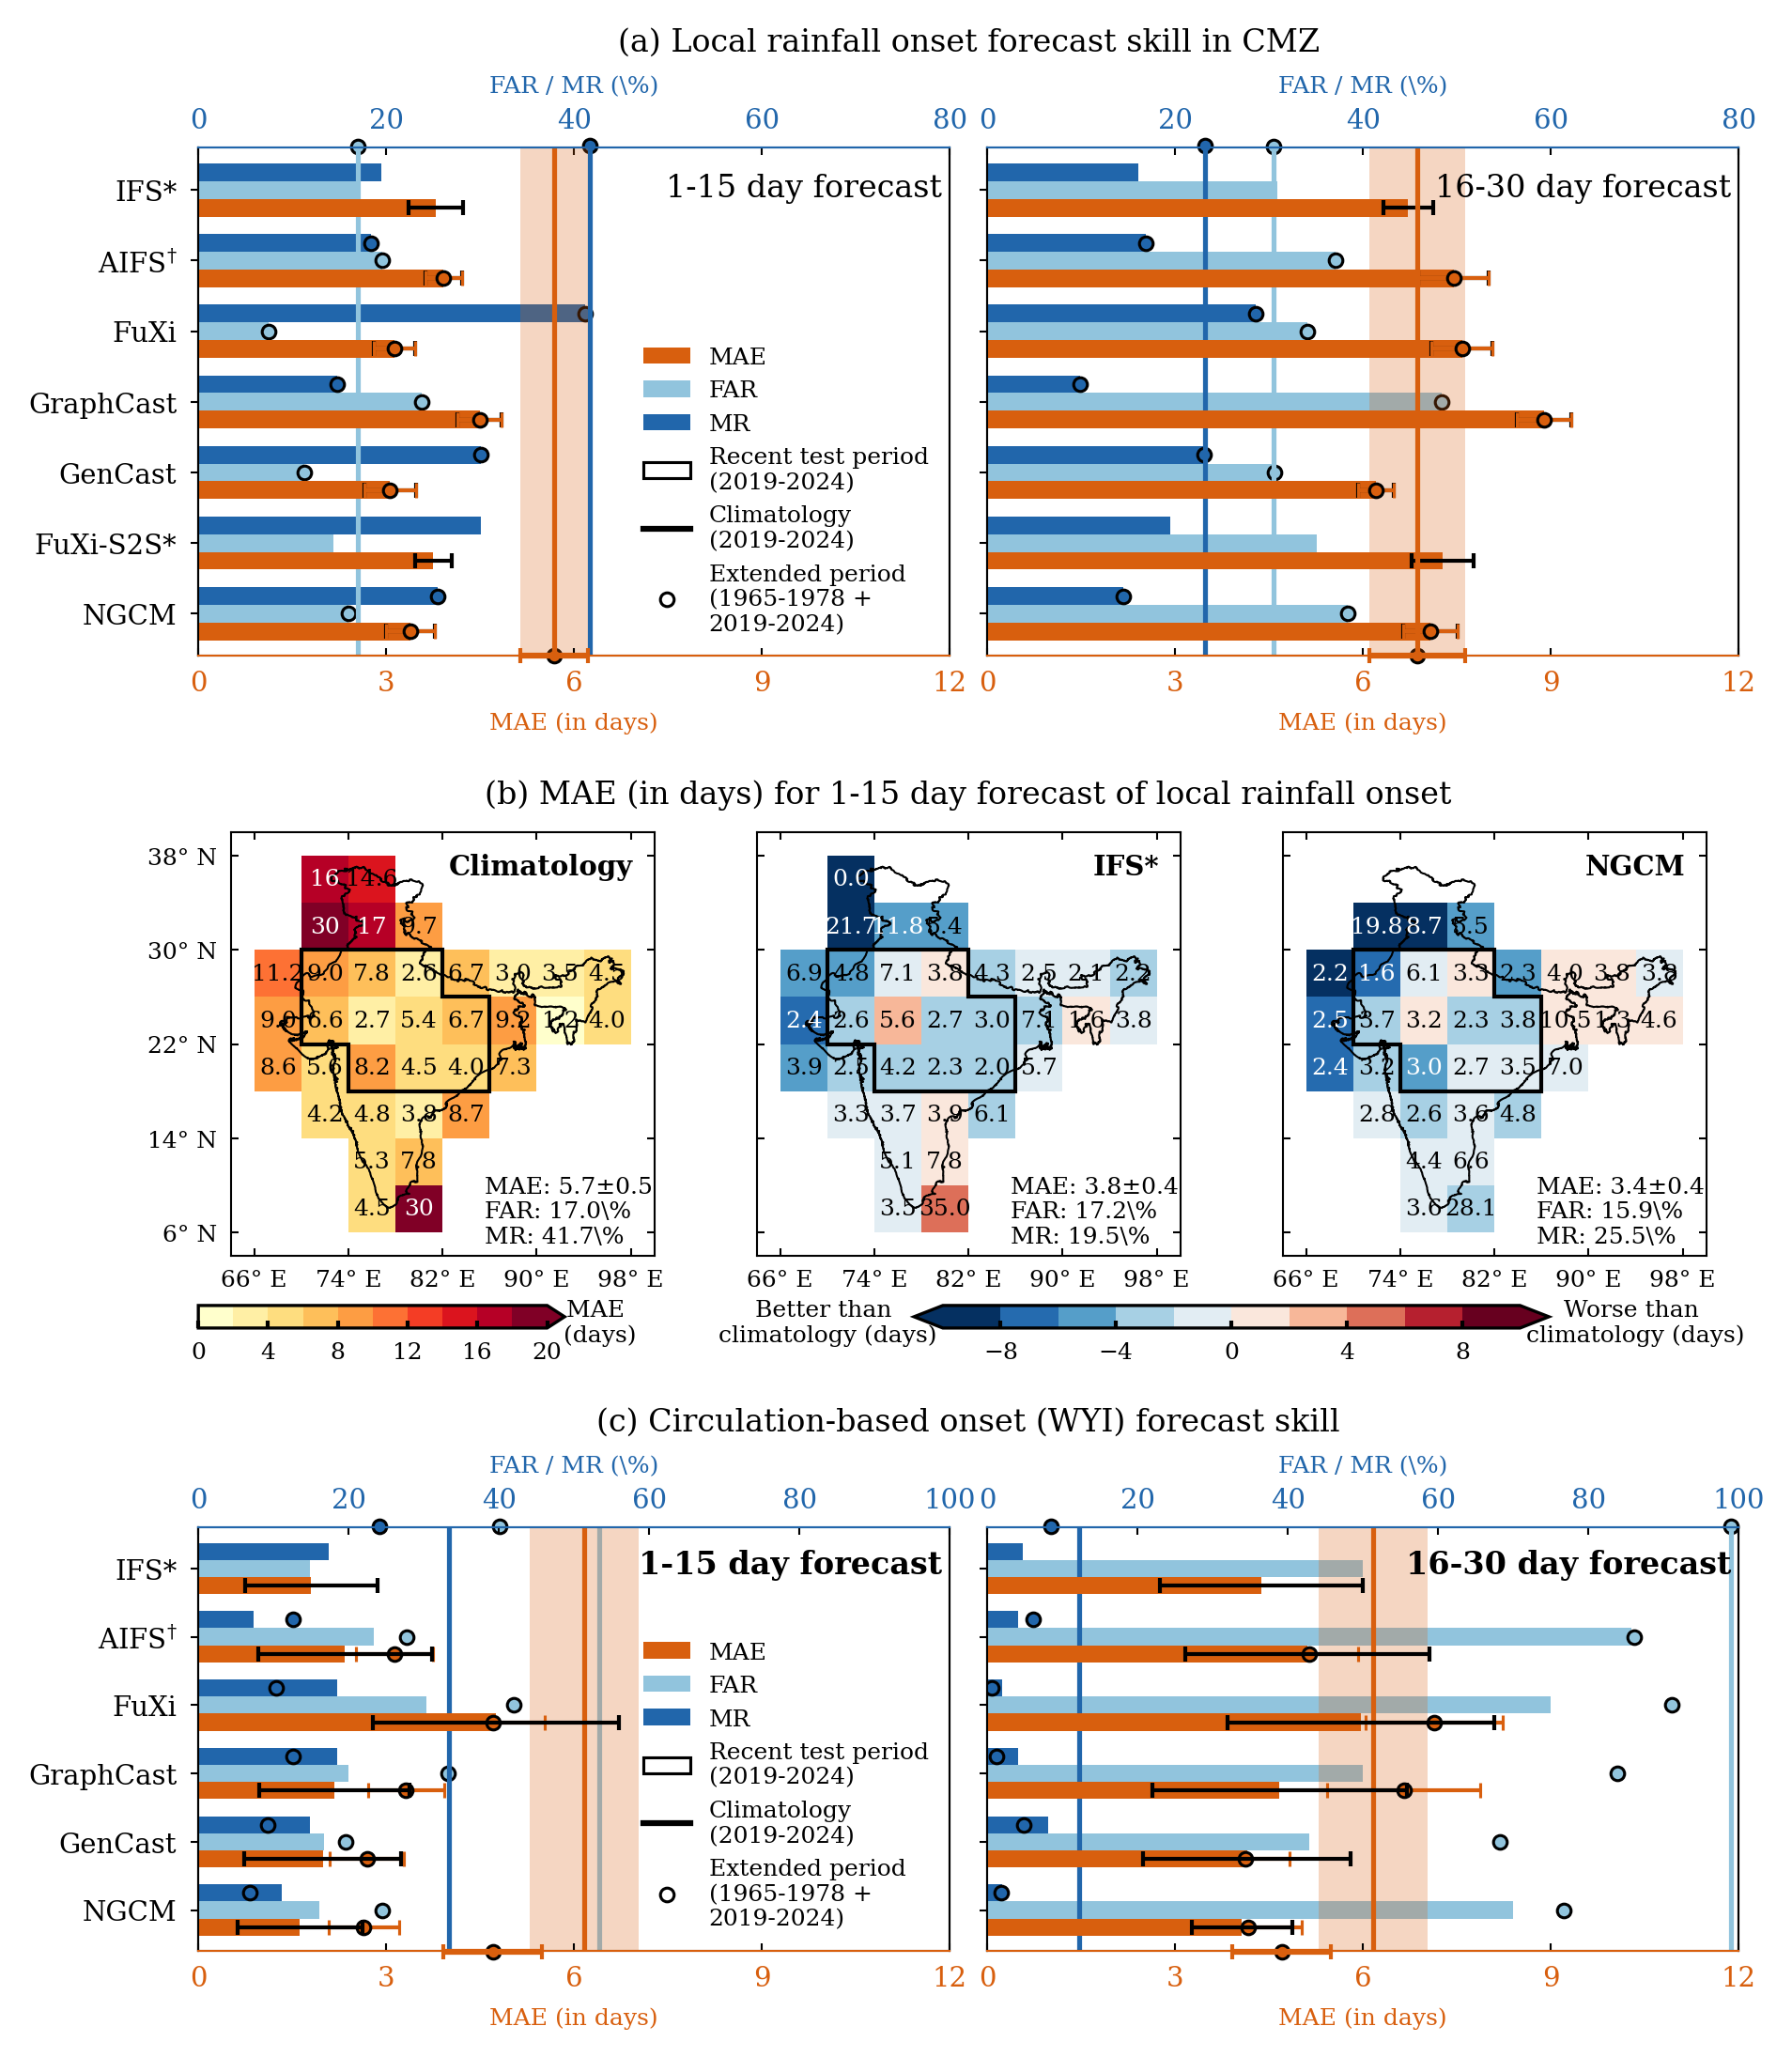

In [58]:
def create_complete_figure_with_differences():
    """Create the complete figure with rearranged panels - bar charts on top, maps below"""

    # Create the main figure
    fig = plt.figure(figsize=(8, 8), dpi=300)
    
    # Create GridSpec - rearranged with bar charts on top
    # Create GridSpec - rearranged with bar charts on top
    gs = GridSpec(
        5, 14, figure=fig,
        hspace=0.4, wspace=0.4,
        left=0.1, right=0.9, top=0.9, bottom=0.1,
        height_ratios=[1.2, -0.1, 1, 0.125, 1]  # First row taller for bar charts
    )

    # Create axes - REARRANGED ORDER
    # Row 0: Bar charts
    ax1 = fig.add_subplot(gs[0, 0:6])   # 15-day metrics
    ax2 = fig.add_subplot(gs[0, 6:12])  # 30-day metrics
    
    # Row 1: 15-day forecast maps
    ax3 = fig.add_subplot(gs[2, 0:4])   # Climatology (15-day)
    ax4 = fig.add_subplot(gs[2, 4:8])   # IFS (15-day) - DIFFERENCE
    ax5 = fig.add_subplot(gs[2, 8:12])  # NGCM (15-day) - DIFFERENCE
    
    # Row 2: Empty spacing row
    
    # Row 3: 30-day forecast maps
    ax6 = fig.add_subplot(gs[4, 0:6])   # WYI onset panels
    ax7 = fig.add_subplot(gs[4, 6:12])   # WYI onset panels

    # NO INDIVIDUAL PANEL TITLES - will add row labels instead
    print("Creating bar chart panels (now top row)...")
    # Panel A: 15-day metrics (moved to top) - NO TITLE
    ax1, ax1_twin = create_bar_panel(
        ax1, mae_cmz_mean_15, std_er_15, far_cmz_mean_15, mr_cmz_mean_15,
        None,  # No title
        mae_cmz_mean_15_extended, std_er_15_extended, far_cmz_mean_15_extended, mr_cmz_mean_15_extended,
        show_ylabel=True, show_legend=True, panel_type='a'
    )

    # Panel B: 30-day metrics (moved to top) - NO TITLE
    ax2, ax2_twin = create_bar_panel(
        ax2, mae_cmz_mean_30, std_er_30, far_cmz_mean_30, mr_cmz_mean_30,
        None,  # No title
        mae_cmz_mean_30_extended, std_er_30_extended, far_cmz_mean_30_extended, mr_cmz_mean_30_extended,
        show_ylabel=False, show_legend=False, panel_type='b'
    )

    # ADD FORECAST PERIOD LABELS TO TOP RIGHT OF BAR PANELS
    ax1.text(0.99, 0.95, '1-15 day forecast', transform=ax1.transAxes,
             horizontalalignment='right', verticalalignment='top',
             fontsize=LARGE_SIZE)

    ax2.text(0.99, 0.95, '16-30 day forecast', transform=ax2.transAxes,
             horizontalalignment='right', verticalalignment='top',
             fontsize=LARGE_SIZE)

    print("Creating 15-day forecast maps (now second row)...")
    # Panel C: 15-day forecast maps (moved to second row) - NO TITLE
    im3 = create_map_panel_no_inset(ax3, mae_avg_15, lon, lat, clim_idx, "Climatology",
                                   mae_cmz_mean_15, std_er_15, far_cmz_mean_15, mr_cmz_mean_15,
                                   vmin=0, vmax=20, n_colors=10, show_ylabel=True, title=None)
    
    im4 = create_map_panel_difference(ax4, mae_avg_15, lon, lat, ifs_idx, clim_idx, "IFS*",
                                     mae_cmz_mean_15, std_er_15, far_cmz_mean_15, mr_cmz_mean_15,
                                     vmin_diff=-10, vmax_diff=10, show_ylabel=False, title=None)
    
    im5 = create_map_panel_difference(ax5, mae_avg_15, lon, lat, ngcm_idx, clim_idx, "NGCM",
                                     mae_cmz_mean_15, std_er_15, far_cmz_mean_15, mr_cmz_mean_15,
                                     vmin_diff=-10, vmax_diff=10, show_ylabel=False, title=None)
    
    print("Creating WYI onset panels (now fourth row)...")
    # Panel D: WYI onset panels - NO TITLE
    ax6, ax6_twin = create_bar_panel_onset(
        ax6, mae_cmz_mean_15_wyi, std_er_15_wyi, far_cmz_mean_15_wyi, mr_cmz_mean_15_wyi,
        mae_cmz_mean_extended_15_wyi, std_er_extended_15_wyi, far_cmz_mean_extended_15_wyi, mr_cmz_mean_extended_15_wyi,
        None,  # No title
        show_ylabel=True, show_legend=True, panel_type='d'
    )
    
    # Panel E: 30-day onset metrics - NO TITLE
    ax7, ax7_twin = create_bar_panel_onset(
        ax7, mae_cmz_mean_30_wyi, std_er_30_wyi, far_cmz_mean_30_wyi, mr_cmz_mean_30_wyi,
        mae_cmz_mean_extended_30_wyi, std_er_extended_30_wyi, far_cmz_mean_extended_30_wyi, mr_cmz_mean_extended_30_wyi,
        None,  # No title
        show_ylabel=False, show_legend=False, panel_type='e'
    )

    # ADD FORECAST PERIOD LABELS TO TOP RIGHT OF WYI ONSET PANELS (two lines)
    ax6.text(0.99, 0.95, '1-15 day forecast', transform=ax6.transAxes,
             horizontalalignment='right', verticalalignment='top',
             fontsize=LARGE_SIZE, fontweight='bold')

    ax7.text(0.99, 0.95, '16-30 day forecast', transform=ax7.transAxes,
             horizontalalignment='right', verticalalignment='top',
             fontsize=LARGE_SIZE, fontweight='bold')

    # ADD ROW LABELS IN THE MIDDLE OF EACH ROW
    # Row 0 label - centered between ax1 and ax2
    pos_ax1 = ax1.get_position()
    pos_ax2 = ax2.get_position()
    middle_x_row0 = (pos_ax1.x1 + pos_ax2.x0) / 2
    fig.text(middle_x_row0, pos_ax1.y1 + 0.04, '(a) Local rainfall onset forecast skill in CMZ', 
             ha='center', va='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    # Row 1 label - centered between all three map panels
    pos_ax3 = ax3.get_position()
    pos_ax5 = ax5.get_position()
    middle_x_row1 = (pos_ax3.x0 + pos_ax5.x1) / 2
    fig.text(middle_x_row1, pos_ax3.y1 + 0.01, '(b) MAE (in days) for 1-15 day forecast of local rainfall onset', 
             ha='center', va='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    # Row 3 label - centered between ax6 and ax7
    pos_ax6 = ax6.get_position()
    pos_ax7 = ax7.get_position()
    middle_x_row3 = (pos_ax6.x1 + pos_ax7.x0) / 2
    fig.text(middle_x_row3, pos_ax6.y1 + 0.04, '(c) Circulation-based onset (WYI) forecast skill', 
             ha='center', va='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    # Colorbar positioning - now for second row (15-day maps)
    pos_panel3 = ax3.get_position()  # Panel 3 (Climatology row 2)
    pos_panel4 = ax4.get_position()  # Panel 4 (IFS row 2)
    pos_panel5 = ax5.get_position()  # Panel 5 (NGCM row 2)
    
    # Create MAE colorbar at the bottom of panel 3 (row 2)
    cax1 = fig.add_axes([
        pos_panel3.x0,                  # x position (start of panel 3)
        pos_panel3.y0 - 0.032,          # y position (below panel 3)
        pos_panel3.width*0.75,          # width
        0.01                          # height
    ])
    
    cbar1 = fig.colorbar(im3, cax=cax1, orientation='horizontal', extend='max')
    cbar1.set_ticks(np.arange(0, 21, 4))
    cbar1.ax.minorticks_off()
    cbar1.ax.tick_params(labelsize = SMALL_SIZE, length=2, width=1)
    cbar1.ax.text(1.15, 0.25, 'MAE \n(days)', transform=cbar1.ax.transAxes, 
              rotation=0, verticalalignment='center', horizontalalignment='center',
              fontsize=SMALL_SIZE, fontweight='normal')
    
    # Create difference colorbar in the middle of panels 4 and 5 (row 2)
    middle_x = (pos_panel4.x0 + pos_panel5.x1) / 2
    colorbar_width = (pos_panel4.width + pos_panel5.width) * 0.65
    
    cax2 = fig.add_axes([
        middle_x - colorbar_width/2,    # x position (centered between panels 4 and 5)
        pos_panel4.y0 - 0.032,          # y position (below row 2)
        colorbar_width,                # width
        0.01                          # height
    ])
    
    cbar2 = fig.colorbar(im4, cax=cax2, orientation='horizontal', extend='both')
    cbar2.set_ticks(np.arange(-8, 9, 4))
    cbar2.ax.text(1.2, 0.25, 'Worse than \nclimatology (days)', transform=cbar2.ax.transAxes, 
              rotation=0, verticalalignment='center', horizontalalignment='center',
              fontsize=SMALL_SIZE, fontweight='normal')
    cbar2.ax.text(-0.2, 0.25, 'Better than \nclimatology (days)', transform=cbar2.ax.transAxes, 
              rotation=0, verticalalignment='center', horizontalalignment='center',
              fontsize=SMALL_SIZE, fontweight='normal')
    cbar2.ax.minorticks_off()
    cbar2.ax.tick_params(labelsize = SMALL_SIZE,length=2, width=1)

    # Styling for map axes (now ax3-ax5)
    map_axes = [ax3, ax4, ax5]
    for ax in map_axes:
        ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE, 
                      length=tick_length, width=tick_width)
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_linewidth(panel_linewidth)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(False)
    
    # Remove x-tick labels from second row (15-day maps)
    #ax3.set_xticklabels([])
    #ax4.set_xticklabels([])
    #ax5.set_xticklabels([])
    
    # Style bar chart axes (now ax1 and ax2)
    ax1.tick_params(axis='x', which='major', labelsize=SMALL_SIZE, 
                   length=tick_length, width=tick_width)
    ax1.tick_params(axis='y', which='major', labelsize=SMALL_SIZE, 
               length=tick_length, width=tick_width, direction='out')
    ax2.tick_params(axis='x', which='major', labelsize=SMALL_SIZE, 
                   length=tick_length, width=tick_width)
    ax2.tick_params(axis='y', which='major', labelsize=SMALL_SIZE, 
                   length=tick_length, width=tick_width, direction='out')
    ax1_twin.tick_params(axis='x', which='major', labelsize=SMALL_SIZE, 
                        length=tick_length, width=tick_width)
    ax2_twin.tick_params(axis='x', which='major', labelsize=SMALL_SIZE, 
                        length=tick_length, width=tick_width)
      
    ax1.tick_params(axis='x', which='major', top=False)
    ax2.tick_params(axis='x', which='major', top=False)
    ax1.tick_params(axis='y', which='major', right=False)
    # Right ticks inward
    ax2.tick_params(axis='y', which='major', left=False, right=True, direction='in')
    # Left ticks outward
    ax2.tick_params(axis='y', which='major', left=True, right=False, direction='out')

    bar_axes1 = [ax1, ax2, ax1_twin, ax2_twin]
    for ax in bar_axes1:
        ax.tick_params(axis='both', which='major', labelsize=MEDIUM_SIZE, length=tick_length, width=tick_width)
        ax.tick_params(axis='x', which='minor', bottom=False, top=False)
        ax.tick_params(axis='y', which='minor', left=False, right=False)
        ax.tick_params(axis='y', which='major', left=True, right=False, direction='out')
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_linewidth(panel_linewidth)

    # Style bar chart axes (row 4)
    bar_axes2 = [ax6, ax7, ax6_twin, ax7_twin]
    for ax in bar_axes2:
        ax.tick_params(axis='both', which='major', labelsize=MEDIUM_SIZE, length=tick_length, width=tick_width)
        ax.tick_params(axis='x', which='minor', bottom=False, top=False)
        ax.tick_params(axis='y', which='minor', left=False, right=False)
        ax.tick_params(axis='y', which='major', left=True, right=False, direction='out')
        
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_linewidth(panel_linewidth)    

    plt.tight_layout()

    plt.savefig('fig1.png', dpi=600, bbox_inches='tight')
    plt.savefig('fig1.pdf', dpi=600, bbox_inches='tight')
    return fig

# Create the rearranged figure
complete_fig_rearranged = create_complete_figure_with_differences()
plt.show()